# Watershed Algorithm and Distance Transform

This notebook provides a concise explanation of the watershed algorithm for image segmentation, focusing on the distance transform and its application to separate overlapping objects.

In [53]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import morphology, segmentation
from skimage.segmentation import watershed
from skimage.draw import disk
import heapq

plt.rcParams['figure.figsize'] = (10, 6)

## 1. Creating a Test Image with Overlapping Objects

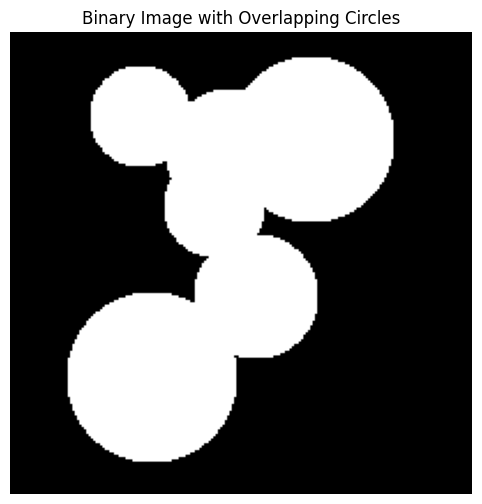

In [28]:
def create_overlapping_circles(shape=(200, 200), num_circles=6, min_radius=20, max_radius=40, seed=42):
    """Create a binary image with overlapping circles"""
    np.random.seed(seed)
    image = np.zeros(shape, dtype=bool)
    
    for _ in range(num_circles):
        radius = np.random.randint(min_radius, max_radius)
        center_y = np.random.randint(radius, shape[0] - radius)
        center_x = np.random.randint(radius, shape[1] - radius)
        
        rr, cc = disk((center_y, center_x), radius)
        valid = (rr >= 0) & (rr < shape[0]) & (cc >= 0) & (cc < shape[1])
        image[rr[valid], cc[valid]] = True
    
    return image

# Create binary image with overlapping circles
binary_image = create_overlapping_circles(seed=100)

# Display the binary image
plt.figure()
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image with Overlapping Circles')
plt.axis('off')
plt.show()

## 2. Distance Transform Explained

The distance transform replaces each foreground pixel with its distance to the nearest background pixel. This creates a "landscape" where the peaks correspond to the centers of objects, and the valleys correspond to boundaries between touching objects.

### Naïve vs. Efficient Implementation

- **Naïve approach**: For each foreground pixel, calculate its distance to every background pixel and take the minimum. This has O(n²m²) complexity for an n×m image.
- **Efficient approach**: Uses dynamic programming to process the image in passes, reducing complexity to O(nm).

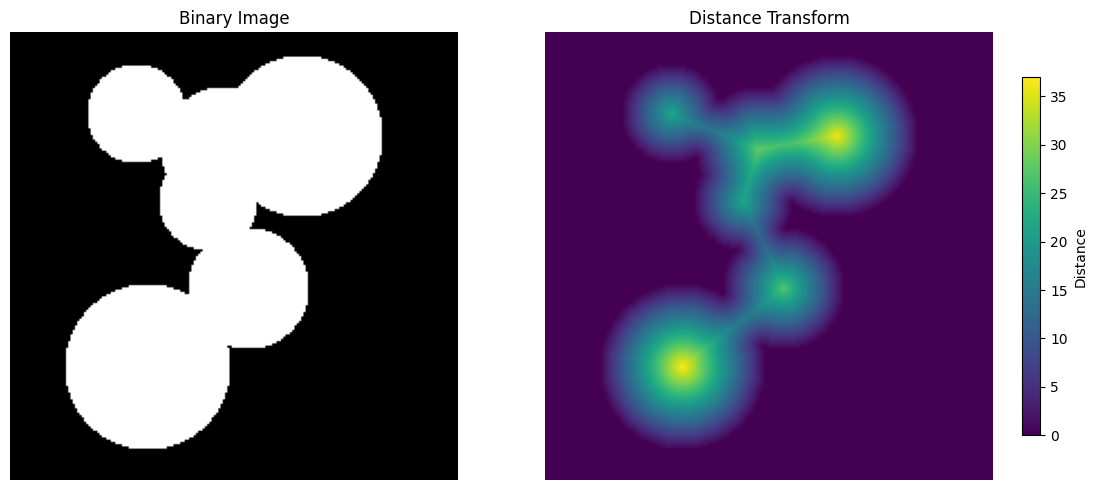

In [31]:
# Calculate the distance transform
distance = ndi.distance_transform_edt(binary_image)

# Visualize the binary image and its distance transform
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(binary_image, cmap='gray')
axes[0].set_title('Binary Image')
axes[0].axis('off')

dt_display = axes[1].imshow(distance, cmap='viridis')
axes[1].set_title('Distance Transform')
axes[1].axis('off')

plt.colorbar(dt_display, ax=axes[1], shrink=0.8, label='Distance')
plt.tight_layout()
plt.show()

## 3. Watershed Algorithm Implementation

The watershed algorithm treats the image as a topographic surface. It starts "flooding" from marker points and creates boundaries where different "floods" meet.

For separating objects:
1. Calculate distance transform
2. Find local maxima as markers (object centers)
3. Apply watershed on the negative distance transform

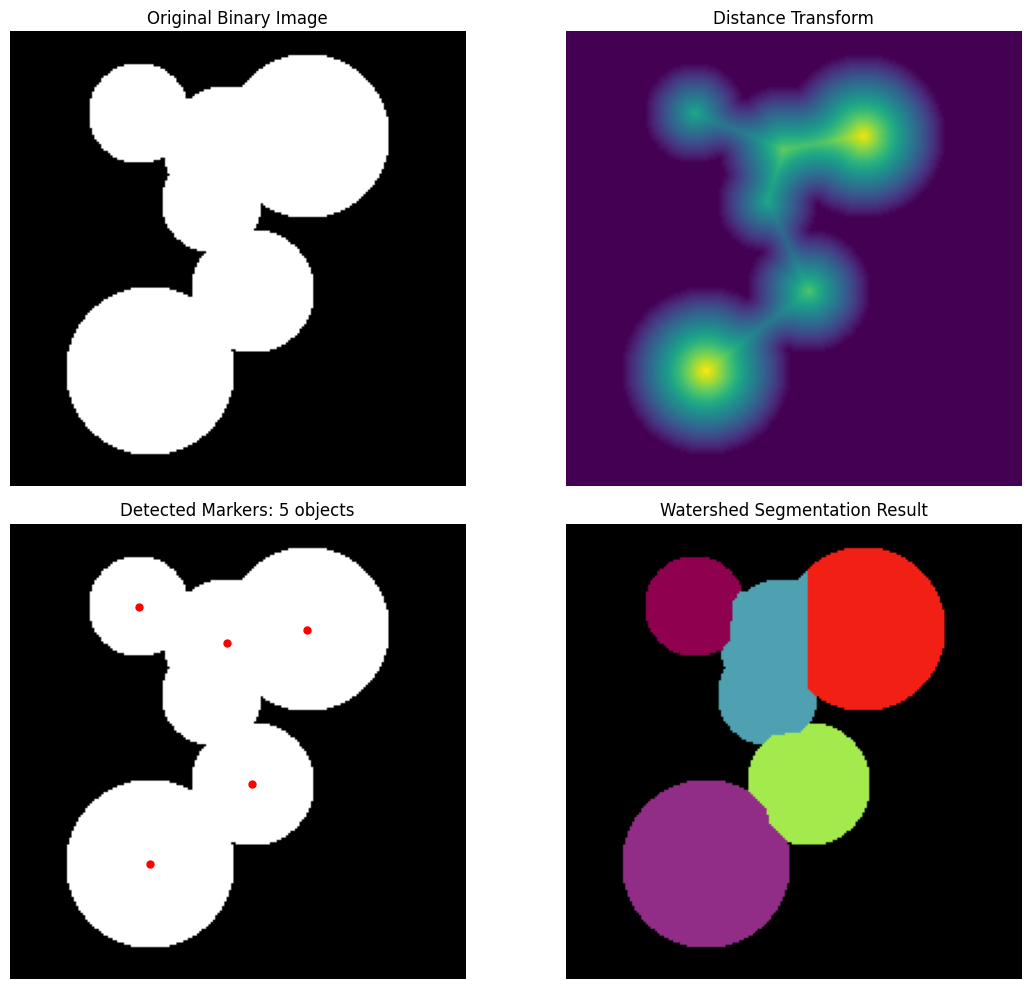

In [34]:
# Find local maxima (markers for watershed)
coords = peak_local_max(distance, min_distance=20, labels=binary_image)

# Create markers for watershed
mask = np.zeros_like(distance, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)

# Apply watershed algorithm
# We use the negative of the distance transform so watershed fills from peaks
labels = watershed(-distance, markers, mask=binary_image)

# Visualize the results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original binary image
axes[0, 0].imshow(binary_image, cmap='gray')
axes[0, 0].set_title('Original Binary Image')
axes[0, 0].axis('off')

# Distance transform
axes[0, 1].imshow(distance, cmap='viridis')
axes[0, 1].set_title('Distance Transform')
axes[0, 1].axis('off')

# Markers
axes[1, 0].imshow(binary_image, cmap='gray')
axes[1, 0].plot(coords[:, 1], coords[:, 0], 'r.', markersize=10)
axes[1, 0].set_title(f'Detected Markers: {len(coords)} objects')
axes[1, 0].axis('off')

# Watershed result
# Create a random colormap for visualization
random_colors = np.random.rand(np.max(labels) + 1, 3)
random_colors[0] = [0, 0, 0]  # Background is black
colored_labels = random_colors[labels]

axes[1, 1].imshow(colored_labels)
axes[1, 1].set_title('Watershed Segmentation Result')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 4. Application: Counting Overlapping Objects

Let's apply the watershed algorithm to a simulated microscopy image with overlapping cells.

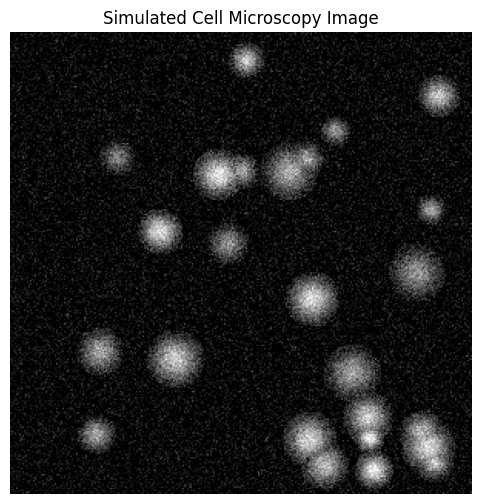

In [37]:
def create_cell_image(shape=(300, 300), num_cells=25, min_radius=10, max_radius=20, noise_level=0.1, seed=1):
    """Create a simulated cell microscopy image"""
    np.random.seed(seed)
    image = np.zeros(shape)
    
    # Add cells as circles with varying intensity
    for _ in range(num_cells):
        radius = np.random.randint(min_radius, max_radius)
        center_y = np.random.randint(radius, shape[0] - radius)
        center_x = np.random.randint(radius, shape[1] - radius)
        intensity = 0.5 + np.random.rand() * 0.5  # Random intensity
        
        rr, cc = disk((center_y, center_x), radius)
        valid = (rr >= 0) & (rr < shape[0]) & (cc >= 0) & (cc < shape[1])
        rr, cc = rr[valid], cc[valid]
        
        # Create cells with gaussian-like intensity profile
        for i, j in zip(rr, cc):
            dist = np.sqrt((i - center_y)**2 + (j - center_x)**2)
            cell_intensity = intensity * np.exp(-(dist**2) / (2 * (radius/2)**2))
            image[i, j] = max(image[i, j], cell_intensity)
    
    # Add noise
    image += np.random.normal(0, noise_level, shape)
    image = np.clip(image, 0, 1)
    
    return image

# Create cell image
cell_image = create_cell_image(seed=20)

# Display the cell image
plt.figure()
plt.imshow(cell_image, cmap='gray')
plt.title('Simulated Cell Microscopy Image')
plt.axis('off')
plt.show()

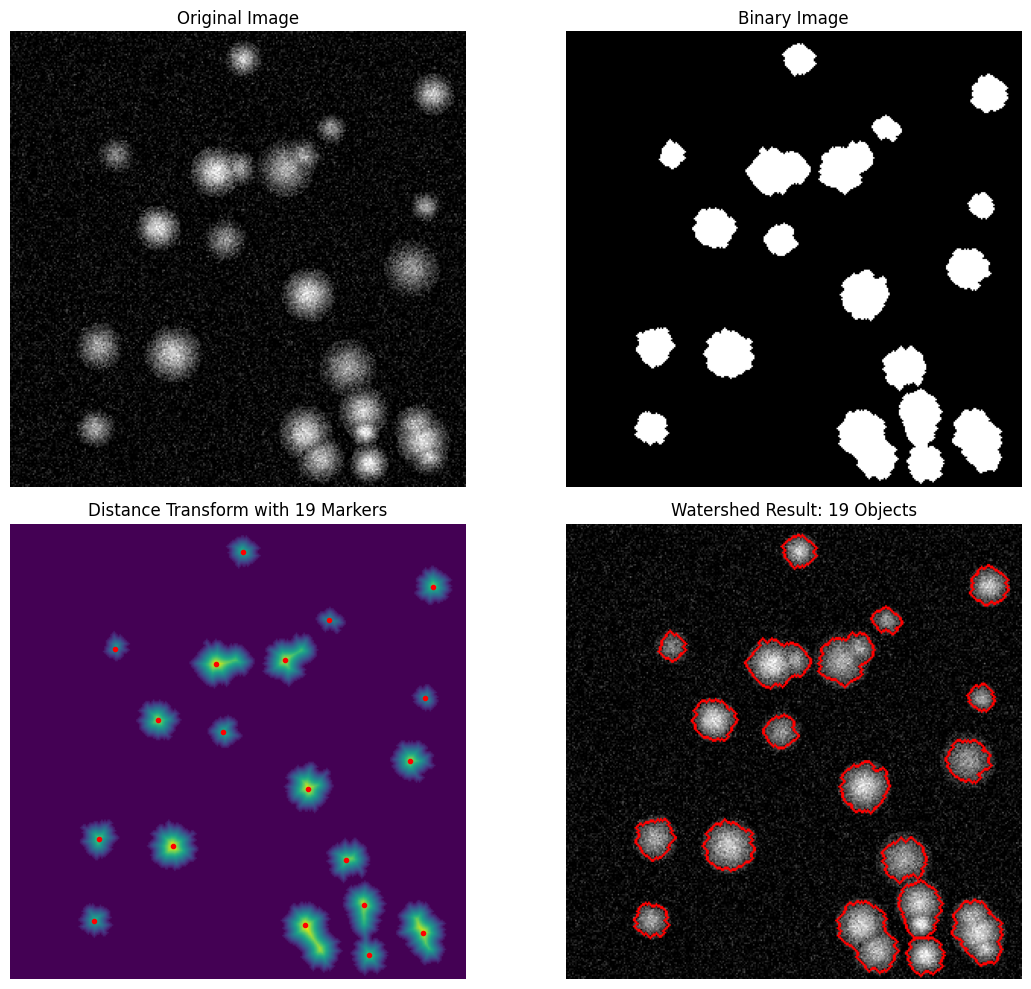

In [39]:
# Process the cell image using watershed
# 1. Threshold the image to get a binary image
threshold = 0.3  # Adjust based on image intensity
binary = cell_image > threshold

# 2. Clean up the binary image
binary = morphology.remove_small_objects(binary, min_size=50)
binary = morphology.binary_dilation(binary, morphology.disk(2))
binary = ndi.binary_fill_holes(binary)

# 3. Calculate distance transform
distance = ndi.distance_transform_edt(binary)

# 4. Find local maxima
coords = peak_local_max(distance, min_distance=15, labels=binary)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)

# 5. Apply watershed
labels = watershed(-distance, markers, mask=binary)

# Create watershed boundaries
boundaries = segmentation.find_boundaries(labels, mode='thick')
overlay = np.stack([cell_image, cell_image, cell_image], axis=-1)  # Convert to RGB
overlay[boundaries] = [1, 0, 0]  # Red boundaries

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(cell_image, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(binary, cmap='gray')
axes[0, 1].set_title('Binary Image')
axes[0, 1].axis('off')

axes[1, 0].imshow(distance, cmap='viridis')
axes[1, 0].plot(coords[:, 1], coords[:, 0], 'r.')
axes[1, 0].set_title(f'Distance Transform with {len(coords)} Markers')
axes[1, 0].axis('off')

axes[1, 1].imshow(overlay)
axes[1, 1].set_title(f'Watershed Result: {np.max(labels)} Objects')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 5. Understanding the Efficient Distance Transform Algorithm

The key insight of the efficient algorithm is breaking the 2D problem into two 1D problems:

1. First pass: compute 1D distance transforms for each row
2. Second pass: compute 1D distance transforms for each column

This works because the Euclidean distance is separable: $(x_1-x_2)^2 + (y_1-y_2)^2$

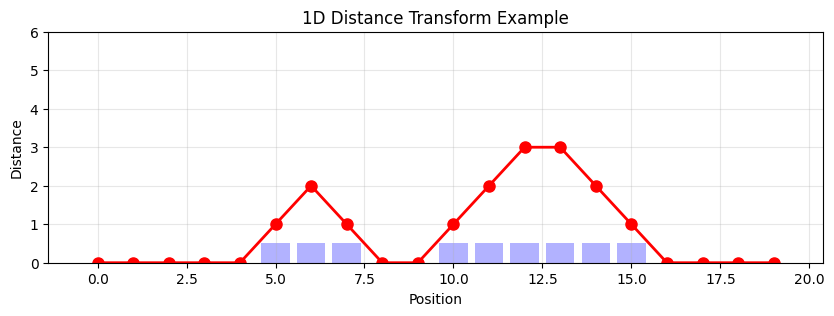

In [41]:
def simplified_1d_dt(binary_array):
    """Simplified 1D distance transform for illustration"""
    n = len(binary_array)
    # Initialize distances as "infinity" for foreground and 0 for background
    dist = np.zeros(n)
    for i in range(n):
        if binary_array[i]:
            dist[i] = float('inf')
    
    # Forward pass
    for i in range(1, n):
        if dist[i] > 0:  # if it's a foreground pixel
            dist[i] = min(dist[i], dist[i-1] + 1)
    
    # Backward pass
    for i in range(n-2, -1, -1):
        if dist[i] > 0:  # if it's a foreground pixel
            dist[i] = min(dist[i], dist[i+1] + 1)
    
    return dist

# Create a sample 1D binary array
binary_1d = np.zeros(20, dtype=bool)
binary_1d[5:8] = True   # First object
binary_1d[10:16] = True  # Second object

# Calculate distance transform
distance_1d = simplified_1d_dt(binary_1d)

# Visualize the result
plt.figure(figsize=(10, 3))
plt.bar(range(len(binary_1d)), [0.5 if b else 0 for b in binary_1d], color='blue', alpha=0.3, width=0.8)
plt.plot(range(len(binary_1d)), distance_1d, 'ro-', linewidth=2, markersize=8)
plt.ylim(0, 6)
plt.title('1D Distance Transform Example')
plt.xlabel('Position')
plt.ylabel('Distance')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Custom Watershed Implementation

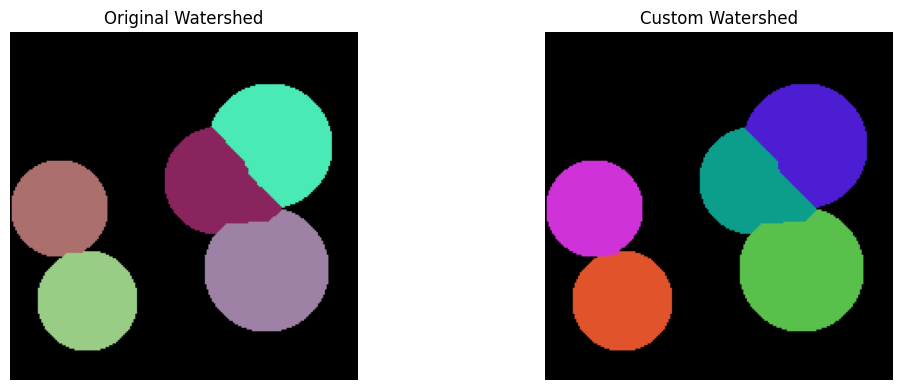

In [57]:
def custom_watershed(distance_map, markers, mask=None):
    """Simplified watershed implementation"""
    if mask is None:
        mask = np.ones_like(distance_map, dtype=bool)
    
    # Queue for flooding
    queue = []
    
    # Initialize labels
    labels = np.zeros_like(markers, dtype=int)
    labels[markers > 0] = markers[markers > 0]
    
    # Neighbor offsets (4-connectivity)
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    # Add marker pixels to queue
    height, width = distance_map.shape
    for y in range(height):
        for x in range(width):
            if markers[y, x] > 0 and mask[y, x]:
                heapq.heappush(queue, (distance_map[y, x], y, x, labels[y, x]))
    
    # Process queue
    while queue:
        val, y, x, label = heapq.heappop(queue)
        
        # Check neighbors
        for dy, dx in neighbors:
            ny, nx = y + dy, x + dx
            
            if (0 <= ny < height and 0 <= nx < width and 
                mask[ny, nx] and labels[ny, nx] == 0):
                
                # Assign label
                labels[ny, nx] = label
                
                # Add to queue
                heapq.heappush(queue, (distance_map[ny, nx], ny, nx, label))
    
    return labels

# Create a small test image
test_binary = create_overlapping_circles(shape=(200, 200), num_circles=7, seed = 10)

# Calculate distance transform
test_distance = ndi.distance_transform_edt(test_binary)

# Find markers
test_coords = peak_local_max(test_distance, min_distance=10, labels=test_binary)
test_mask = np.zeros_like(test_binary, dtype=bool)
test_mask[tuple(test_coords.T)] = True
test_markers, _ = ndi.label(test_mask)

# Apply both original and custom watershed
test_labels_orig = watershed(-test_distance, test_markers, mask=test_binary)
test_labels_custom = custom_watershed(-test_distance, test_markers, mask=test_binary)

# Show results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original watershed
random_colors = np.random.rand(np.max(test_labels_orig) + 1, 3)
random_colors[0] = [0, 0, 0]
colored_orig = random_colors[test_labels_orig]
axes[0].imshow(colored_orig)
axes[0].set_title('Original Watershed')
axes[0].axis('off')

# Custom watershed
random_colors = np.random.rand(np.max(test_labels_custom) + 1, 3)
random_colors[0] = [0, 0, 0]
colored_custom = random_colors[test_labels_custom]
axes[1].imshow(colored_custom)
axes[1].set_title('Custom Watershed')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Conclusion

The watershed algorithm combined with the distance transform provides an effective way to separate overlapping objects in images. Key points:

1. **Distance Transform**: Maps each foreground pixel to its distance from the background
2. **Efficient Implementation**: Uses dynamic programming to reduce complexity from O(n²m²) to O(nm)
3. **Watershed Segmentation**: Treats the distance transform as a topographic surface and floods from markers
4. **Applications**: Cell counting, bacterial colony analysis, particle segmentation

Advantages:
- Handles touching/overlapping objects well
- Works with objects of varying sizes
- Computationally efficient

Limitations:
- Sensitive to noise (can lead to over-segmentation)
- Requires good marker selection